###### Regression: predicting a continuous value
Predict median price of homes in a given Boston suburb in the mid-1970s. The dataset has total 506 data points and features have different scales

In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 2us/step


In [2]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [3]:
# Targets are median values of owner-occupied homes, in thousands of dollars
print(train_targets[0:10])

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


In [18]:
# Feature-wise normalization to make learning more efficient:
# in each column, subtract mean and then divide by standard deviation
mean = np.mean(train_data, axis=0)
train_data -= mean
std = np.std(train_data, axis=0)
train_data /= std

test_data -= mean
test_data /= std

Note that the quantities used to normalize test data are calculated from training data. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.

In [19]:
from keras import models
from keras import layers

def build_model(_input_shape):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=_input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Linear layer (no activation)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

###### Few points about the model definition from above
* A dense layers with no activation is a suitable last layer for scalar regression --- using an activation would constrain the output
* Mean squared error (MSE) is widely used loss function for regression
* MAE stands for mean absolute error
* When little training data is available, it's preferable to use a small network with few hidden layers (typically only one or two), in order to aviod severe overfitting

###### K-fold validation
In situations where available dataset is relatively small, a simple train,test split would result in a very small validation set. As a consequence, the validation scores might change a lot depending on which data points you chose to use for validation and which you chose for training: the validation scores might have a high variance with regard to the validation split. This would pre- vent you from reliably evaluating your model. The best practice in such situations is to use K-fold validation: split dataset into K partitions, create K identical models, and train each model on K-1 partitions while evaluating on the remaining partition. Typically, K=4 or 5.

In [23]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k

In [20]:
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model=build_model((partial_train_data.shape[1],))
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0) # silent mode
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [21]:
print(all_scores)

[2.401572064598008, 2.6137070372553155, 2.8014562200791766, 2.458033250700129]


In [22]:
print(np.mean(all_scores))

2.5686921431581573


The average mean absolute error on 4-fold validation is more reliable validation error, as compared to single validation experiment. The number indicates that 2.568 thousand dollars is the average difference in the prediction of housing prices on the validation data, which is significant considering the prices range from \$10,000 to $50,000.

In [24]:
# Now let's run the model for 500 epochs and save per-epoch validation score log
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model=build_model((partial_train_data.shape[1],))
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0) # silent mode
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [25]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

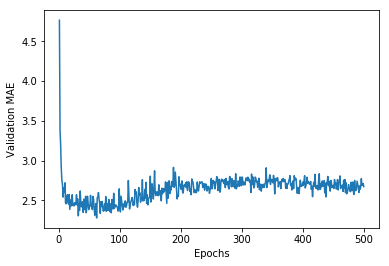

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

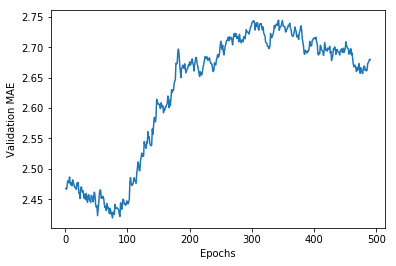

In [28]:
# Improve the previous plot by:
# (1) Omit the first 10 data points, which are on a different scale than the rest of the curve
# (2) Replace each point with an exponential moving average of the previous points, to obtain a smooth curve

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs. Past that point, we start overfitting. Once we have finished tuning model parameters (we could also do the similar experiment for size of layers), we can train the final production model on all of the training data, with the best parameters, and then look at its performance on the test data.

In [29]:
model = build_model((train_data.shape[1],))
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

102/102 [==============================] - 0s 1ms/step
2.5880035606085086


The final result indicates that we are still off by about \$2588.